<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/cnn3_50epoch_flower_D_c_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.5 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 402MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=128, nch_d=128, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:22<00:00,  1.25it/s]


epoch: 0, lossD:3.164100567186342, lossG:21.52764439814299,lossG_fake:15.461026215437547, lossG_real:6.06661813207043 ,equality:9.394408083367118


evaluate:83.65377807617188,kid_mean:0.03313491865992546, kid_std:0.011007769033312798,kid_:(tensor(0.0331), tensor(0.0110))


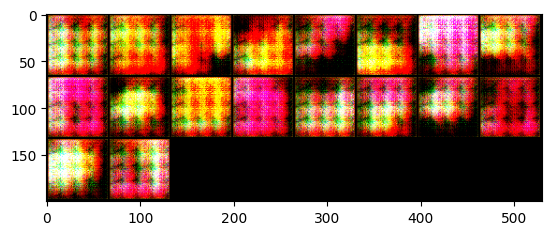

100%|██████████| 103/103 [00:19<00:00,  5.39it/s]


epoch: 1, lossD:1.720820444301494, lossG:8.259032031864797,lossG_fake:4.946418586865212, lossG_real:3.3126134316898086 ,equality:1.6338051551754034


evaluate:93.5797119140625,kid_mean:0.04498285427689552, kid_std:0.023898005485534668,kid_:(tensor(0.0450), tensor(0.0239))


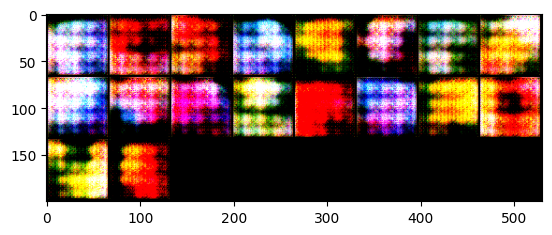

100%|██████████| 103/103 [00:19<00:00,  5.32it/s]


epoch: 2, lossD:1.4756635470876416, lossG:7.129127655214476,lossG_fake:4.145519308673525, lossG_real:2.9836083581146684 ,equality:1.1619109505588567


evaluate:94.35588836669922,kid_mean:0.052406519651412964, kid_std:0.027013123035430908,kid_:(tensor(0.0524), tensor(0.0270))


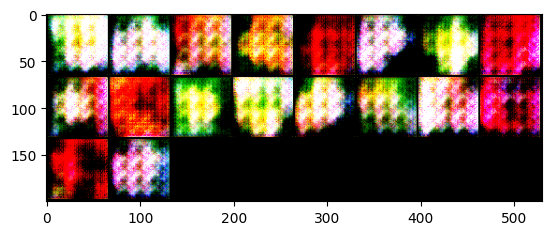

100%|██████████| 103/103 [00:19<00:00,  5.26it/s]


epoch: 3, lossD:1.6149142731740638, lossG:7.171588291242284,lossG_fake:4.334497691358178, lossG_real:2.837090637498689 ,equality:1.4974070538594888


evaluate:87.05738830566406,kid_mean:0.04673140496015549, kid_std:0.023008348420262337,kid_:(tensor(0.0467), tensor(0.0230))


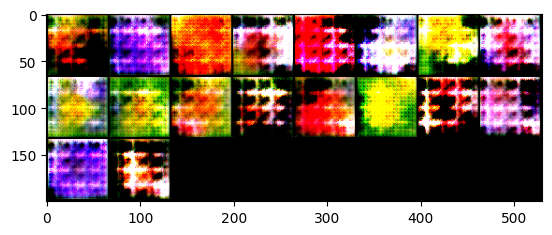

100%|██████████| 103/103 [00:19<00:00,  5.22it/s]


epoch: 4, lossD:1.465578127543903, lossG:6.605041036328066,lossG_fake:3.9522801967500483, lossG_real:2.6527608355272165 ,equality:1.2995193612228317


evaluate:99.6911849975586,kid_mean:0.061666879802942276, kid_std:0.03225146606564522,kid_:(tensor(0.0617), tensor(0.0323))


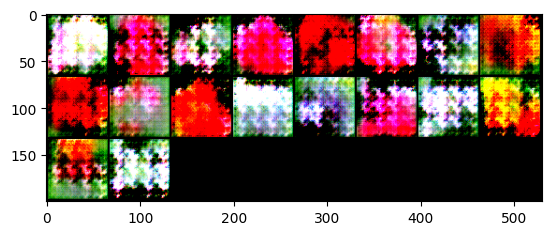

100%|██████████| 103/103 [00:19<00:00,  5.17it/s]


epoch: 5, lossD:1.5458034386912596, lossG:6.462056933097469,lossG_fake:3.863449824666514, lossG_real:2.5986071052481825 ,equality:1.2648427194183314


evaluate:85.81195068359375,kid_mean:0.05965311825275421, kid_std:0.030442247167229652,kid_:(tensor(0.0597), tensor(0.0304))


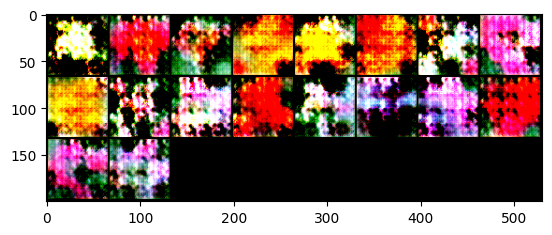

100%|██████████| 103/103 [00:19<00:00,  5.16it/s]


epoch: 6, lossD:1.4196476380801895, lossG:6.426369296694265,lossG_fake:3.7819847863854714, lossG_real:2.6443844917908454 ,equality:1.137600294594626


evaluate:80.88462829589844,kid_mean:0.056647781282663345, kid_std:0.03359908238053322,kid_:(tensor(0.0566), tensor(0.0336))


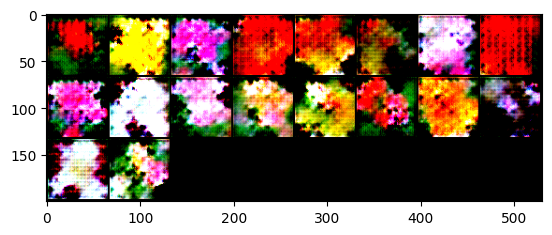

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 7, lossD:1.3159241201808152, lossG:6.252126990012752,lossG_fake:3.666887812244082, lossG_real:2.5852391951292466 ,equality:1.0816486171148352


evaluate:77.23512268066406,kid_mean:0.052948933094739914, kid_std:0.0278308242559433,kid_:(tensor(0.0529), tensor(0.0278))


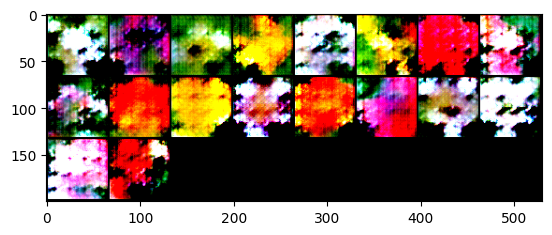

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 8, lossD:1.2897302065659495, lossG:6.597683605638522,lossG_fake:3.8948359049639656, lossG_real:2.70284770588273 ,equality:1.1919881990812358


evaluate:76.3133316040039,kid_mean:0.0455985926091671, kid_std:0.031221264973282814,kid_:(tensor(0.0456), tensor(0.0312))


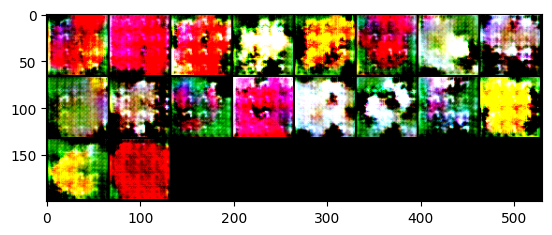

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 9, lossD:1.3575855713446163, lossG:6.246555944090908,lossG_fake:3.6847921089061257, lossG_real:2.5617638299766097 ,equality:1.123028278929516


evaluate:80.06573486328125,kid_mean:0.05069269984960556, kid_std:0.0317748486995697,kid_:(tensor(0.0507), tensor(0.0318))


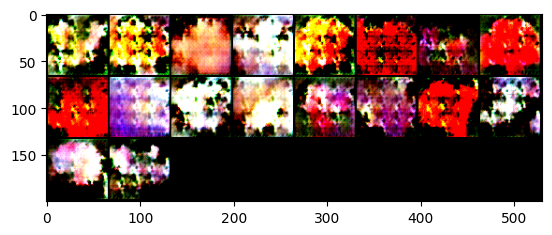

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 10, lossD:1.4083086929274995, lossG:5.9243846958123365,lossG_fake:3.4804142574662142, lossG_real:2.4439704366100643 ,equality:1.03644382085615


evaluate:85.93395233154297,kid_mean:0.05919137969613075, kid_std:0.032817989587783813,kid_:(tensor(0.0592), tensor(0.0328))


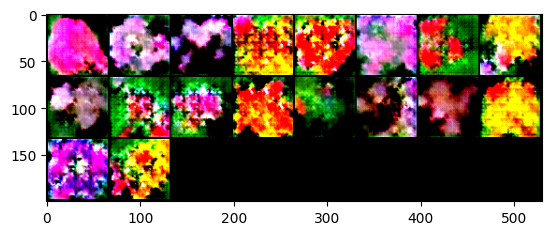

100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


epoch: 11, lossD:1.3462948585019527, lossG:6.130205256267659,lossG_fake:3.564499836523556, lossG_real:2.5657054061449847 ,equality:0.9987944303785712


evaluate:88.88379669189453,kid_mean:0.05264374613761902, kid_std:0.03163033723831177,kid_:(tensor(0.0526), tensor(0.0316))


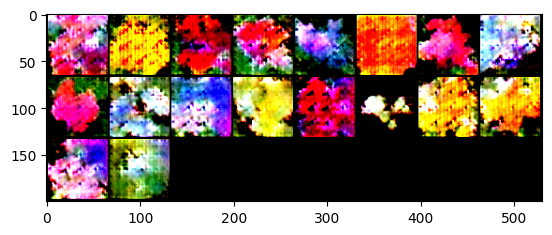

100%|██████████| 103/103 [00:20<00:00,  5.10it/s]


epoch: 12, lossD:1.3388765633684918, lossG:5.846870871423517,lossG_fake:3.3894201360859917, lossG_real:2.457450734180154 ,equality:0.9319694019058375


evaluate:89.64401245117188,kid_mean:0.06303244829177856, kid_std:0.03741521015763283,kid_:(tensor(0.0630), tensor(0.0374))


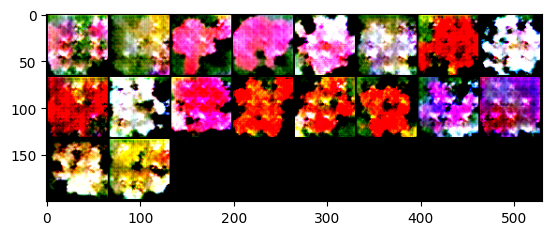

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 13, lossD:1.428751717782715, lossG:5.905544702289174,lossG_fake:3.411423415813631, lossG_real:2.494121277505912 ,equality:0.9173021383077193


evaluate:92.17398834228516,kid_mean:0.06721855700016022, kid_std:0.03735330328345299,kid_:(tensor(0.0672), tensor(0.0374))


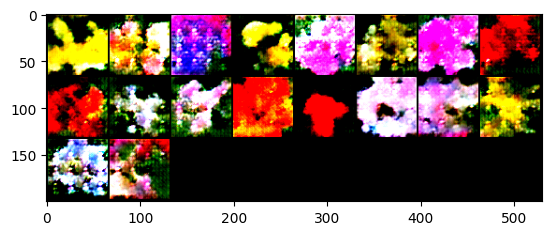

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 14, lossD:1.2360925011843154, lossG:6.050708659644266,lossG_fake:3.4587914764302448, lossG_real:2.591917197102482 ,equality:0.8668742793277628


evaluate:89.92764282226562,kid_mean:0.0670895054936409, kid_std:0.035070616751909256,kid_:(tensor(0.0671), tensor(0.0351))


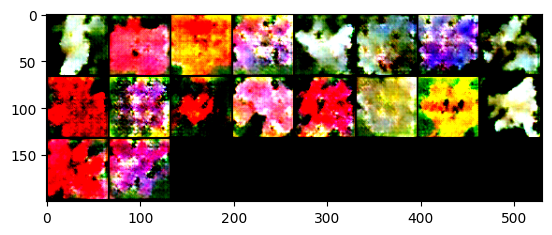

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 15, lossD:1.21754576077739, lossG:6.104375260547527,lossG_fake:3.5164060650519953, lossG_real:2.587969197810275 ,equality:0.9284368672417203


evaluate:87.86377716064453,kid_mean:0.06386218219995499, kid_std:0.04638874530792236,kid_:(tensor(0.0639), tensor(0.0464))


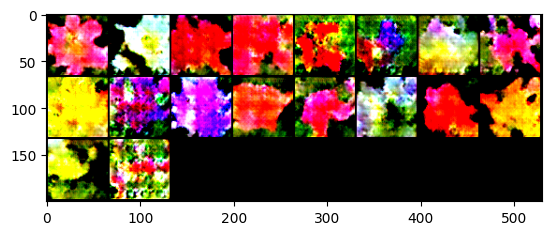

100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


epoch: 16, lossD:1.2773581835830097, lossG:6.054079671507901,lossG_fake:3.4344985265176273, lossG_real:2.6195811345739273 ,equality:0.8149173919437


evaluate:82.23110961914062,kid_mean:0.06176147609949112, kid_std:0.03505955636501312,kid_:(tensor(0.0618), tensor(0.0351))


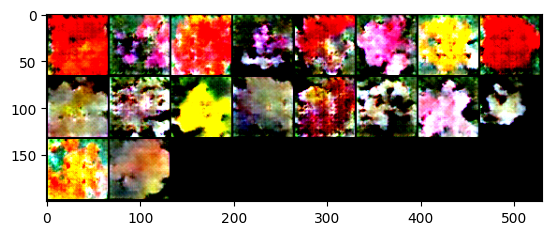

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 17, lossD:1.1984305726092996, lossG:6.179921108542136,lossG_fake:3.43711915930498, lossG_real:2.742801950828543 ,equality:0.6943172084764369


evaluate:84.57745361328125,kid_mean:0.06475812941789627, kid_std:0.037588246166706085,kid_:(tensor(0.0648), tensor(0.0376))


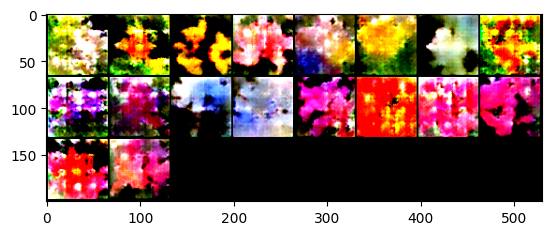

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 18, lossD:1.168455971965512, lossG:6.424364451065804,lossG_fake:3.7058023596272887, lossG_real:2.718562075524654 ,equality:0.9872402841026346


evaluate:83.26062774658203,kid_mean:0.06272376328706741, kid_std:0.03648436442017555,kid_:(tensor(0.0627), tensor(0.0365))


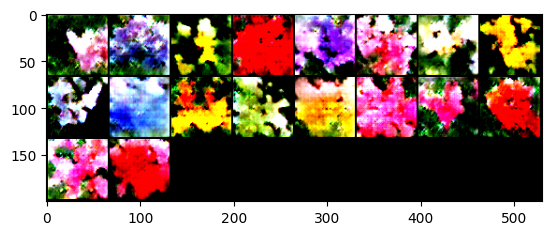

100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


epoch: 19, lossD:1.2097567768351545, lossG:6.21370969698267,lossG_fake:3.4606151789137463, lossG_real:2.753094504180464 ,equality:0.7075206747332823


evaluate:84.46692657470703,kid_mean:0.064097099006176, kid_std:0.039410874247550964,kid_:(tensor(0.0641), tensor(0.0394))


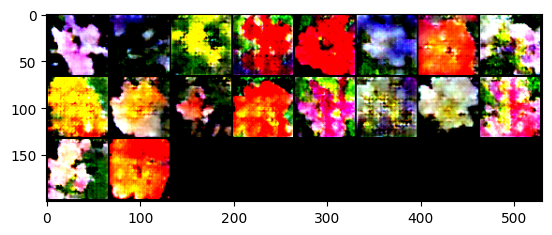

100%|██████████| 103/103 [00:20<00:00,  5.10it/s]


epoch: 20, lossD:1.1415564898148323, lossG:6.395899138404328,lossG_fake:3.6193137510308944, lossG_real:2.776585417465099 ,equality:0.8427283335657956


evaluate:82.89522552490234,kid_mean:0.0659656897187233, kid_std:0.031908001750707626,kid_:(tensor(0.0660), tensor(0.0319))


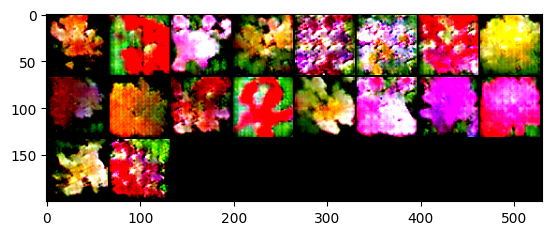

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 21, lossD:1.1207085312570182, lossG:6.425841729617813,lossG_fake:3.6229355757676283, lossG_real:2.8029061743935335 ,equality:0.8200294013740947


evaluate:80.38536071777344,kid_mean:0.06040610745549202, kid_std:0.035068150609731674,kid_:(tensor(0.0604), tensor(0.0351))


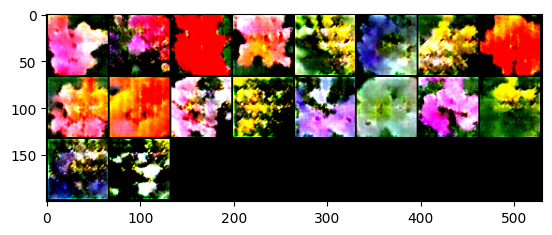

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 22, lossD:1.1436180278514196, lossG:6.4342384060609685,lossG_fake:3.5928346555209854, lossG_real:2.8414037407023236 ,equality:0.7514309148186618


evaluate:82.64253234863281,kid_mean:0.05551505088806152, kid_std:0.03269876167178154,kid_:(tensor(0.0555), tensor(0.0327))


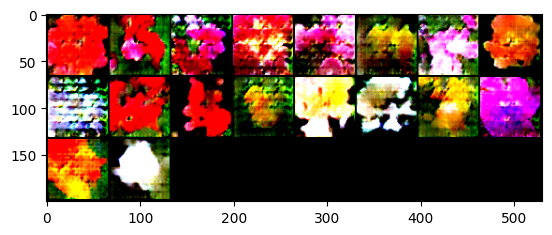

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 23, lossD:1.1235768711103977, lossG:6.522945144801464,lossG_fake:3.6356461516861778, lossG_real:2.887298967074422 ,equality:0.748347184611756


evaluate:84.26786804199219,kid_mean:0.06537844985723495, kid_std:0.03992221876978874,kid_:(tensor(0.0654), tensor(0.0399))


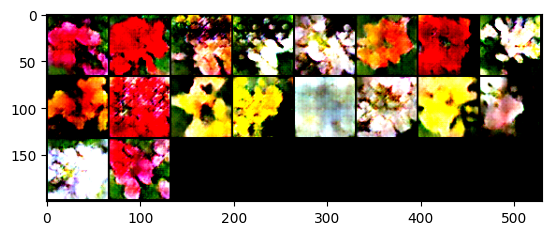

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 24, lossD:1.131079046471605, lossG:6.448071877933243,lossG_fake:3.6408911335815506, lossG_real:2.807180762001612 ,equality:0.8337103715799388


evaluate:84.90499114990234,kid_mean:0.06921794265508652, kid_std:0.04261128231883049,kid_:(tensor(0.0692), tensor(0.0426))


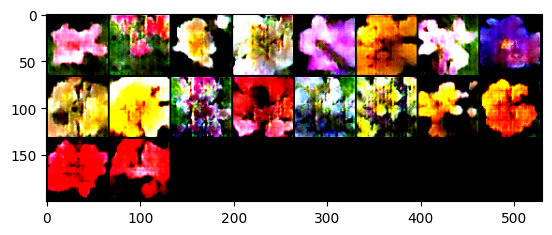

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 25, lossD:1.089113400977792, lossG:6.70360476299397,lossG_fake:3.782969140312047, lossG_real:2.9206356221032372 ,equality:0.8623335182088097


evaluate:85.24880981445312,kid_mean:0.06188875064253807, kid_std:0.03721810132265091,kid_:(tensor(0.0619), tensor(0.0372))


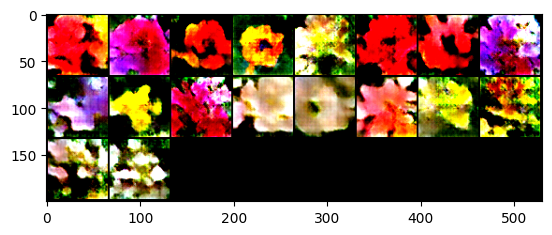

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 26, lossD:1.101228920580114, lossG:6.580338042916604,lossG_fake:3.698002373130576, lossG_real:2.8823356469279355 ,equality:0.8156667262026405


evaluate:87.70178985595703,kid_mean:0.06330034136772156, kid_std:0.039674192667007446,kid_:(tensor(0.0633), tensor(0.0397))


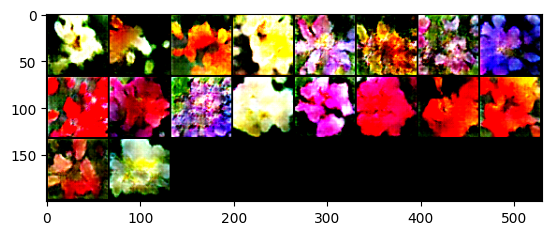

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 27, lossD:1.0591432706823627, lossG:6.660712302309795,lossG_fake:3.74451648957521, lossG_real:2.9161958421028933 ,equality:0.8283206474723168


evaluate:86.58383178710938,kid_mean:0.05983199179172516, kid_std:0.037626996636390686,kid_:(tensor(0.0598), tensor(0.0376))


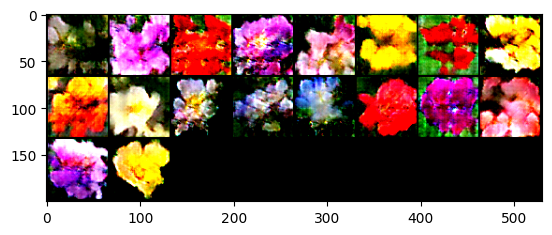

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 28, lossD:0.9307638354671811, lossG:7.052333174399959,lossG_fake:3.938065347162265, lossG_real:3.114267832445867 ,equality:0.8237975147163983


evaluate:86.6727523803711,kid_mean:0.06261886656284332, kid_std:0.036161210387945175,kid_:(tensor(0.0626), tensor(0.0362))


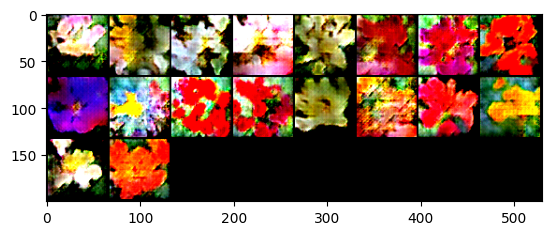

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 29, lossD:1.0995034332414275, lossG:6.852807415341868,lossG_fake:3.912322146221272, lossG_real:2.940485284166429 ,equality:0.9718368620548432


evaluate:87.8878402709961,kid_mean:0.06291715800762177, kid_std:0.0298188216984272,kid_:(tensor(0.0629), tensor(0.0298))


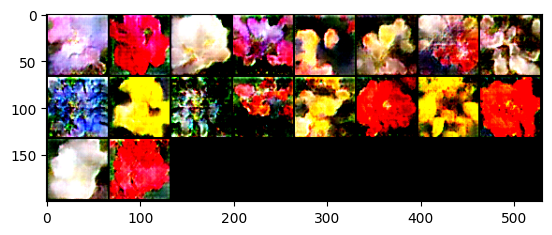

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 30, lossD:0.9465657504438196, lossG:6.704006903379867,lossG_fake:3.687835246613882, lossG_real:3.0161716683397017 ,equality:0.6716635782741802


evaluate:86.95536804199219,kid_mean:0.07203090935945511, kid_std:0.04057307168841362,kid_:(tensor(0.0720), tensor(0.0406))


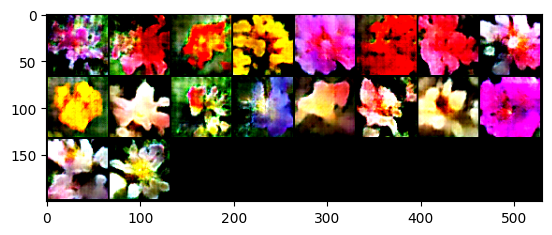

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 31, lossD:0.9829919552340091, lossG:6.843045049500697,lossG_fake:3.804756405284104, lossG_real:3.0382886421911923 ,equality:0.7664677630929115


evaluate:89.06595611572266,kid_mean:0.06347683817148209, kid_std:0.04103747010231018,kid_:(tensor(0.0635), tensor(0.0410))


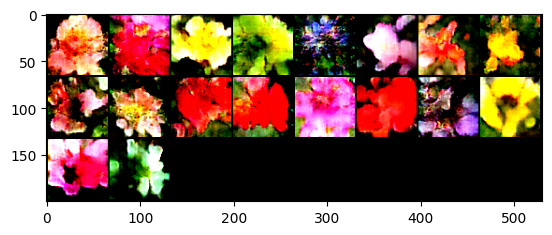

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 32, lossD:0.9233561375187439, lossG:7.004174547288025,lossG_fake:3.8709706588856223, lossG_real:3.133203891874517 ,equality:0.7377667670111054


evaluate:88.84085845947266,kid_mean:0.05813273414969444, kid_std:0.03650958091020584,kid_:(tensor(0.0581), tensor(0.0365))


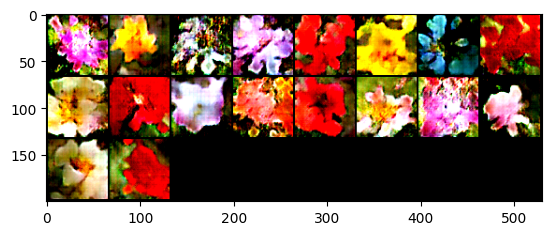

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 33, lossD:0.9055284698611324, lossG:7.0854283305047785,lossG_fake:3.8972111205452853, lossG_real:3.1882172255840118 ,equality:0.7089938949612735


evaluate:88.45140075683594,kid_mean:0.056369103491306305, kid_std:0.034054674208164215,kid_:(tensor(0.0564), tensor(0.0341))


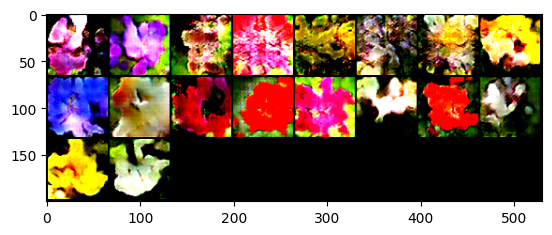

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 34, lossD:0.8763604259606704, lossG:7.102936906721985,lossG_fake:3.971528149345546, lossG_real:3.1314087851533614 ,equality:0.8401193641921845


evaluate:89.20243835449219,kid_mean:0.057767294347286224, kid_std:0.03474661335349083,kid_:(tensor(0.0578), tensor(0.0347))


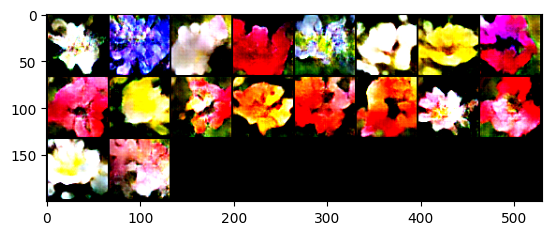

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 35, lossD:0.9233958988079747, lossG:7.1969261586087425,lossG_fake:4.00592848398153, lossG_real:3.1909976740485257 ,equality:0.8149308099330046


evaluate:88.20447540283203,kid_mean:0.060960397124290466, kid_std:0.03508215397596359,kid_:(tensor(0.0610), tensor(0.0351))


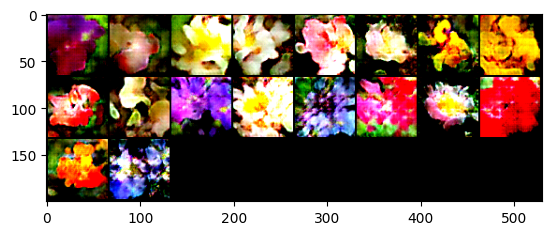

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 36, lossD:0.9216754585504532, lossG:7.376783713553715,lossG_fake:4.147376815670902, lossG_real:3.229406872999321 ,equality:0.917969942671581


evaluate:87.99687957763672,kid_mean:0.06637769192457199, kid_std:0.042102519422769547,kid_:(tensor(0.0664), tensor(0.0421))


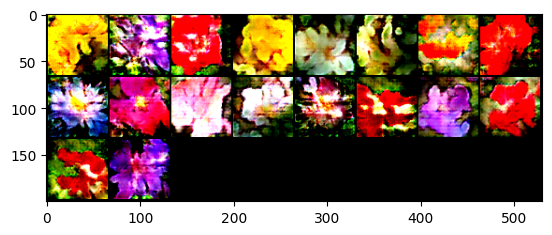

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 37, lossD:0.8215035650770641, lossG:7.200314595861342,lossG_fake:3.9851009741570187, lossG_real:3.215213617653523 ,equality:0.7698873565034958


evaluate:88.0335922241211,kid_mean:0.06113056838512421, kid_std:0.036970287561416626,kid_:(tensor(0.0611), tensor(0.0370))


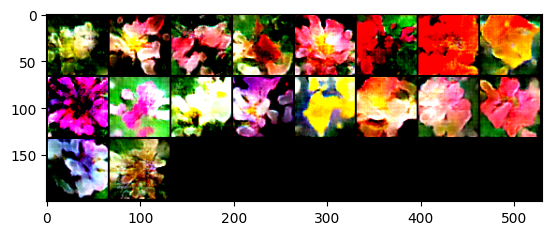

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 38, lossD:0.8903079691153128, lossG:7.364237081657335,lossG_fake:4.1124205901784805, lossG_real:3.2518164903214832 ,equality:0.8606040998569973


evaluate:88.2238998413086,kid_mean:0.0605020634829998, kid_std:0.03592255339026451,kid_:(tensor(0.0605), tensor(0.0359))


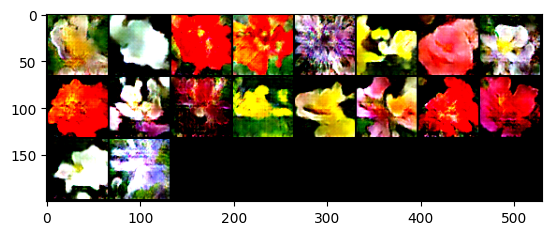

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 39, lossD:0.9073268667008113, lossG:7.341772565563906,lossG_fake:4.097804799820613, lossG_real:3.243967764585921 ,equality:0.8538370352346925


evaluate:89.20179748535156,kid_mean:0.0585307702422142, kid_std:0.03413715958595276,kid_:(tensor(0.0585), tensor(0.0341))


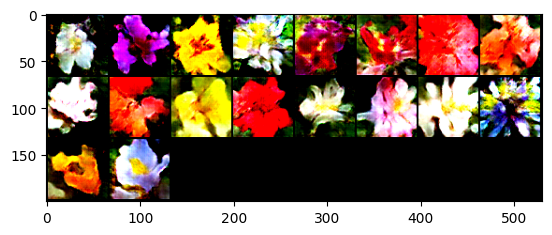

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 40, lossD:0.9037442803382874, lossG:7.29447412027896,lossG_fake:3.9881939100987704, lossG_real:3.3062802026572737 ,equality:0.6819137074414967


evaluate:90.40675354003906,kid_mean:0.05785398185253143, kid_std:0.02737434394657612,kid_:(tensor(0.0579), tensor(0.0274))


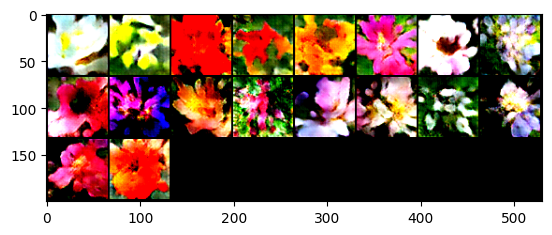

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 41, lossD:0.9021535832615732, lossG:7.420072138888164,lossG_fake:4.074227056457001, lossG_real:3.345845067674674 ,equality:0.7283819887823273


evaluate:90.3812484741211,kid_mean:0.06346752494573593, kid_std:0.031587451696395874,kid_:(tensor(0.0635), tensor(0.0316))


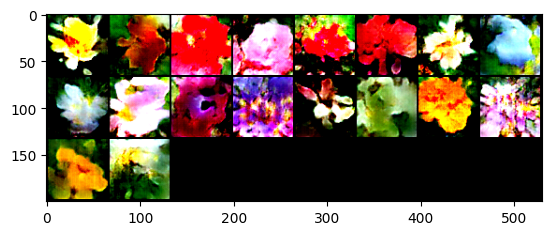

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 42, lossD:0.8523918640555688, lossG:7.208870498879442,lossG_fake:3.954665920109425, lossG_real:3.2542046175419705 ,equality:0.7004613025674544


evaluate:92.22040557861328,kid_mean:0.06013519689440727, kid_std:0.03585614636540413,kid_:(tensor(0.0601), tensor(0.0359))


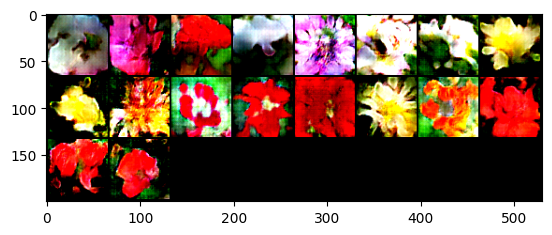

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 43, lossD:1.027008665128819, lossG:7.081786859382704,lossG_fake:3.8745260568498407, lossG_real:3.207260784014915 ,equality:0.6672652728349258


evaluate:93.14614868164062,kid_mean:0.06731794029474258, kid_std:0.03701922297477722,kid_:(tensor(0.0673), tensor(0.0370))


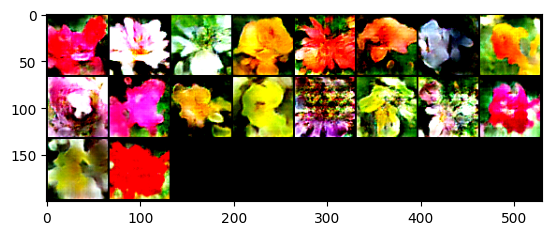

100%|██████████| 103/103 [00:20<00:00,  5.10it/s]


epoch: 44, lossD:0.8088650266522343, lossG:7.279169142824932,lossG_fake:3.9587860281027636, lossG_real:3.3203831124074252 ,equality:0.6384029156953384


evaluate:95.11958312988281,kid_mean:0.06407764554023743, kid_std:0.0361943244934082,kid_:(tensor(0.0641), tensor(0.0362))


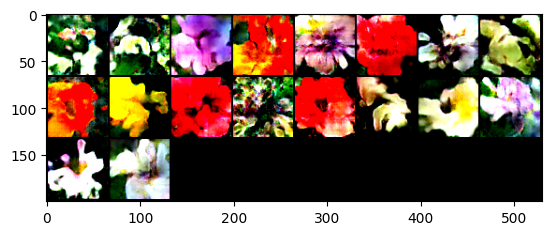

100%|██████████| 103/103 [00:20<00:00,  5.09it/s]


epoch: 45, lossD:0.8149508289920474, lossG:7.354558143800902,lossG_fake:4.007538797207249, lossG_real:3.3470193408067943 ,equality:0.6605194564004546


evaluate:95.12933349609375,kid_mean:0.06592720746994019, kid_std:0.044054023921489716,kid_:(tensor(0.0659), tensor(0.0441))


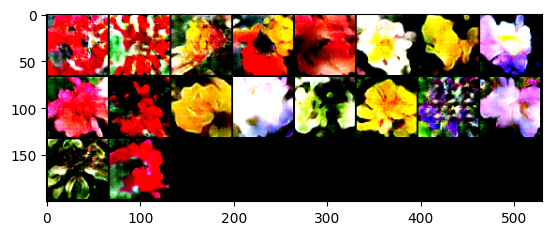

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 46, lossD:0.8430458820849946, lossG:7.538954494068924,lossG_fake:4.153211003368341, lossG_real:3.385743486071096 ,equality:0.7674675172972449


evaluate:96.15181732177734,kid_mean:0.0677582174539566, kid_std:0.0428701750934124,kid_:(tensor(0.0678), tensor(0.0429))


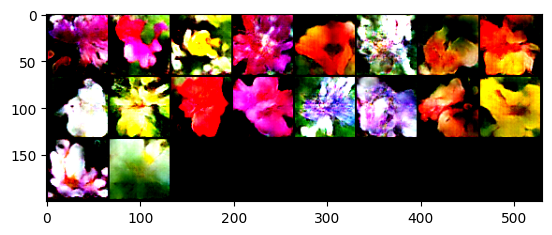

100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


epoch: 47, lossD:0.7973480103085342, lossG:7.50255572217182,lossG_fake:4.095868293521474, lossG_real:3.4066874419601216 ,equality:0.6891808515613524


evaluate:96.47611236572266,kid_mean:0.07245568931102753, kid_std:0.036458976566791534,kid_:(tensor(0.0725), tensor(0.0365))


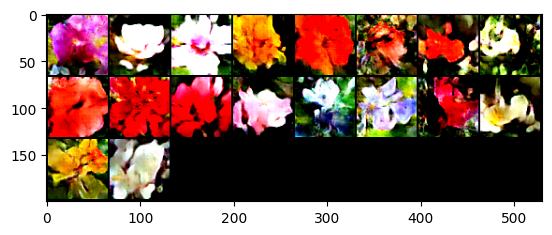

100%|██████████| 103/103 [00:20<00:00,  5.06it/s]


epoch: 48, lossD:0.8180243160250118, lossG:7.585820698043675,lossG_fake:4.142150431003385, lossG_real:3.4436702418674545 ,equality:0.6984801891359305


evaluate:96.3440170288086,kid_mean:0.06492634862661362, kid_std:0.03917614370584488,kid_:(tensor(0.0649), tensor(0.0392))


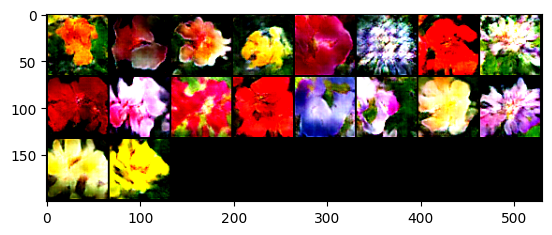

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 49, lossD:0.7038208866871677, lossG:7.703493095138698,lossG_fake:4.174296377353298, lossG_real:3.5291967258870023 ,equality:0.6450996514662957


evaluate:96.31595611572266,kid_mean:0.06554260849952698, kid_std:0.04317161813378334,kid_:(tensor(0.0655), tensor(0.0432))


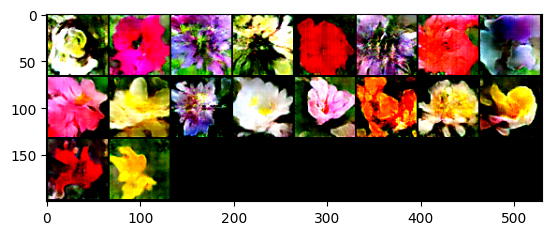

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

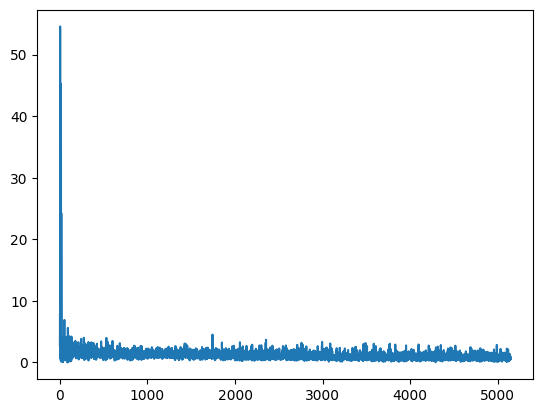

In [45]:
plt.plot(raw_lossesD)

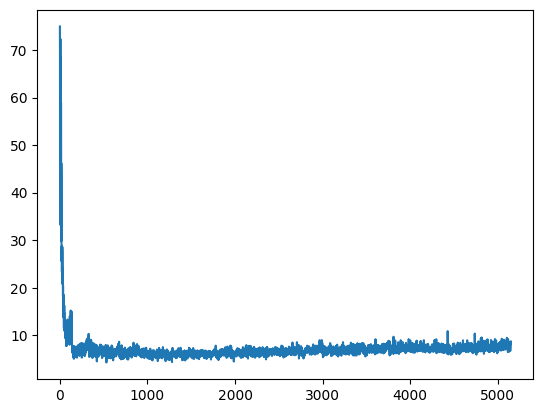

In [46]:
plt.plot(raw_lossesG)

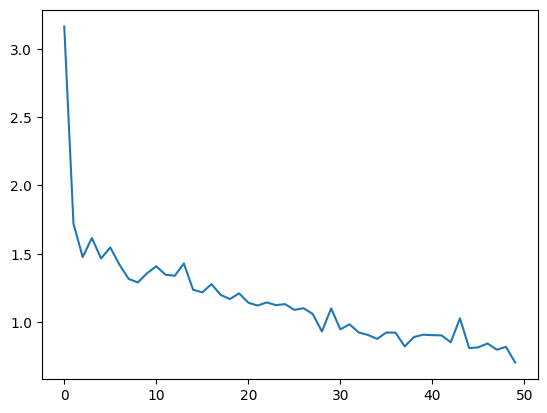

In [47]:
plt.plot(lossesD)

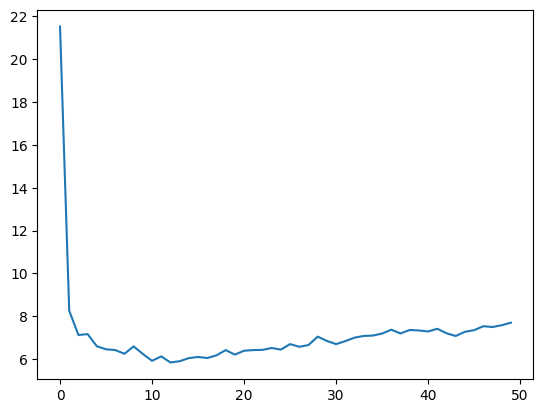

In [48]:
plt.plot(lossesG)

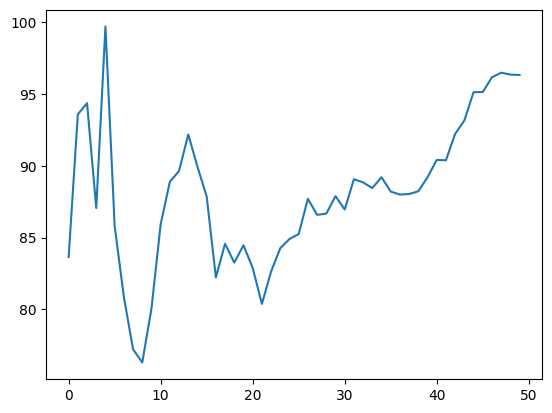

In [49]:
plt.plot(fid_)

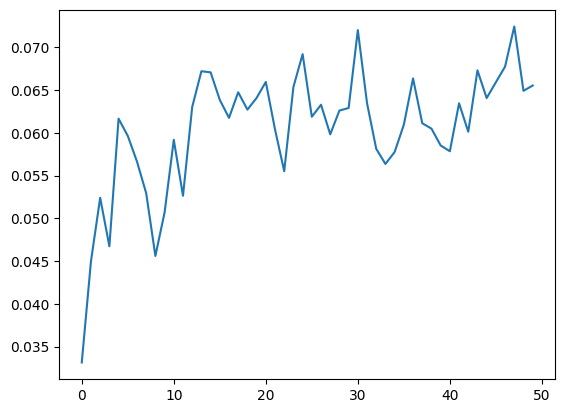

In [50]:
plt.plot(kid_mean_)

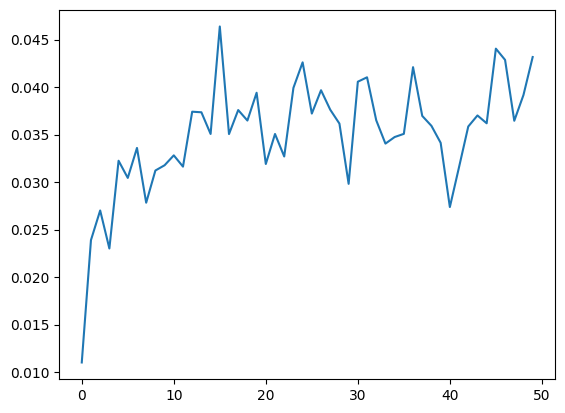

In [51]:
plt.plot(kid_std_)

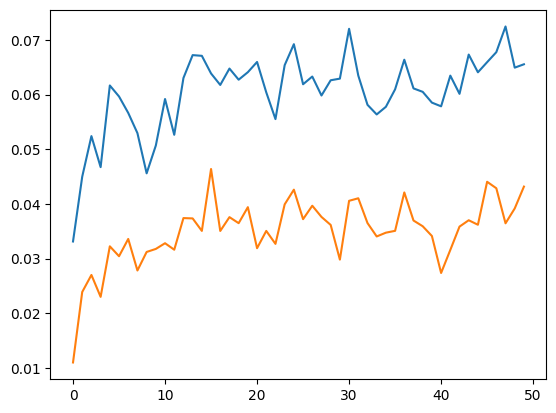

In [52]:
plt.plot(kid_score)

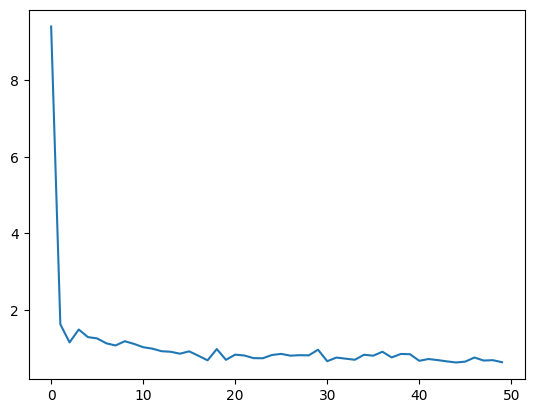

In [53]:
plt.plot(d_equality)

In [54]:

import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.0 MB/s eta 0:00:00
fid  tensor(96.2915)
kid  (tensor(0.0645), tensor(0.0431))
PSNR tensor(74.1747)
SSIM値: 0.9590333920885767
